# Machine Learning Assignment 2

Amiru Chandrasena & Kelvin Young

# Classifying Cells Bassed On Type

The Cells Dataset contains two components: one component is the CSV document containing the features about the cell and the cells' corresponding image URL. Secondly, there is also a folder of images on cells in PNG format.

# [1] Reading In The Data

The first step of data analysis is reading in the data from the CSV file. Secondly, the next step is exploring the data to look for errors and trends in the dataset that may help with optimizing the approach and the model.

In [43]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataSet_cells = pd.read_csv('data/data_labels_mainData.csv')


## [1.1] Exploring The Data

Exploring the data involves firstly checking the head and the tail of the data to ensure that the CSV file has been completely read in without errors. This includes checking the first couple of records, the last records, and the features. Secondly, the next step is to check for missing values to ensure that the model is not introduced to incomplete data and interfering with the performance of the model.

In [44]:
dataSet_cells.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
5,22410,1,22410.png,fibroblast,0,0
6,22411,1,22411.png,fibroblast,0,0
7,22412,1,22412.png,fibroblast,0,0
8,22413,1,22413.png,fibroblast,0,0
9,22414,1,22414.png,fibroblast,0,0


In [45]:
dataSet_cells.tail(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9886,1616,60,1616.png,epithelial,2,1
9887,1617,60,1617.png,epithelial,2,1
9888,1618,60,1618.png,epithelial,2,1
9889,1619,60,1619.png,epithelial,2,1
9890,1624,60,1624.png,epithelial,2,1
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1
9895,1629,60,1629.png,epithelial,2,1


In [46]:
dataSet_cells.tail(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9886,1616,60,1616.png,epithelial,2,1
9887,1617,60,1617.png,epithelial,2,1
9888,1618,60,1618.png,epithelial,2,1
9889,1619,60,1619.png,epithelial,2,1
9890,1624,60,1624.png,epithelial,2,1
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1
9895,1629,60,1629.png,epithelial,2,1


In [47]:
null_counts = dataSet_cells.isnull().sum()

print(null_counts)

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


In [48]:
dataSet_cells.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [49]:
dataSet_cells.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

## [1.2] Stripping Features 

It is important to drop unimportant features from the dataset. For example, features like 'InstanceID' and 'patientID' may be irrelevant to the training of the model. The only important information that is used is the numeric column called 'cellType', which assigns a numeric value to the 'cellTypeName' attributes, and the 'ImageName'.

In [50]:
import pandas as pd

# Drop the specified features
dataSet_cells.drop(["InstanceID", "patientID", "cellTypeName", "isCancerous"], axis=1, inplace=True)
dataSet_cells.head()

,ImageName,cellType
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


## [1.3] Splitting The Dataset Into Training, Validaiton and Testing Sets

Splitting the dataset into three sections, namely the training set, validation set, and test set, allows for effective testing of the model. Allocating 80% (5937) of the dataset to the training set enables the model to learn and improve its accuracy. The validation set is used to evaluate the model's performance without exposing it to the final test data, which remains unseen. The validation set helps in assessing the model's accuracy, identifying overfitting or underfitting issues, and determining suitable hyperparameters.

Using a histogram, we can check if the distribution of attributes in the training set is approximately equal to the distribution in the test set. This step is crucial for the following reasons:

Generalization: Ensuring that the data in both the validation and test sets is a fair representation of the whole dataset increases the likelihood that the model will be able to generalize well to unseen data. If the test set has a significantly different distribution, the model may struggle to make accurate predictions because it hasn't learned the relevant patterns or variations during training. By maintaining similar distributions, we enhance the model's ability to generalize its learnings.
Bias and Representation: If the data in the validation set is skewed or unrepresentative of the whole dataset, it can introduce bias and lead to misleading evaluation metrics. Having a representative validation set helps in obtaining reliable performance measures and making informed decisions about the model's effectiveness.
In summary, ensuring an approximately equal distribution of attributes between the training and test sets, as well as having a representative validation set, contributes to the development of a robust and reliable model capable of generalizing well to unseen data.

Train data : (5937, 2), Val Data: (1979, 2), Test Data: (1980, 2)


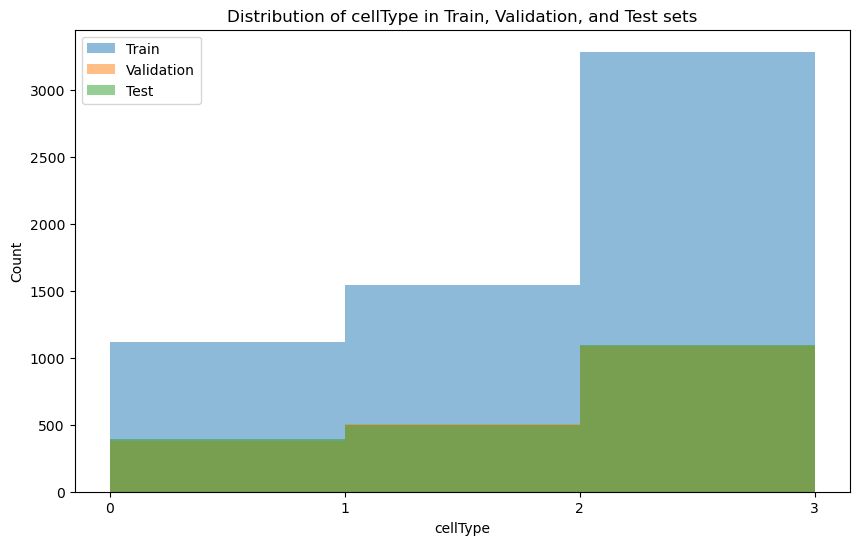

In [51]:
# We split the data into 80% of training Data, 10% Validation and 10% Testing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


train_data, test_data = train_test_split(dataSet_cells, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape, val_data.shape, test_data.shape))

# Plot histogram for train set
plt.figure(figsize=(10, 6))
plt.hist(train_data['cellType'], bins=range(4), alpha=0.5, label='Train')
plt.hist(val_data['cellType'], bins=range(4), alpha=0.5, label='Validation')
plt.hist(test_data['cellType'], bins=range(4), alpha=0.5, label='Test')
plt.xlabel('cellType')
plt.ylabel('Count')
plt.title('Distribution of cellType in Train, Validation, and Test sets')
plt.xticks(range(4))
plt.legend()
plt.show()


The graph above illustrates the data distribution, and it is evident that the validation and test sets exhibit striking similarity and accurately represent the entire dataset.

# [2] Model Development

## [2.1] Base Model

The base model starts by specifying the image dimensions as (16163), converting it into an array. Next, the hidden layer is defined with 256 neurons, which will be fine-tuned later to optimize the model's performance. Lastly, since there are four distinct cell types, the model has four output classes.

In [52]:
INPUT_DIM = (16,16,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

## [2.2] Create a sequential API to build the model

In TensorFlow, there are three main types of models, and for this neural network, the Sequential model was used. The Sequential model is chosen for its simplicity and the ability to build models layer by layer, making it easier to train.

In this specific model, three layers were incorporated. Firstly, the image is flattened, as mentioned earlier, to prepare it for further processing. This layer does not involve any learning; it is solely responsible for image processing.

The second layer is where the actual learning takes place, as it uses a sigmoid activation function. This layer learns patterns and features from the input data to make predictions.

Lastly, the final layer is responsible for providing the output results of the model. It produces the predicted values based on the learned features and patterns from the previous layers.

In [53]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM), ## Flatten the images into (16x16x3) array
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               196864    
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 197,892
Trainable params: 197,892
Non-trainable params: 0
_________________________________________________________________


In the code above, tf.keras.regularisers.l2(0.01) is used to apply L2 regularisation with a regularisation parameter of 0.01 to the weights of the Dense layer.

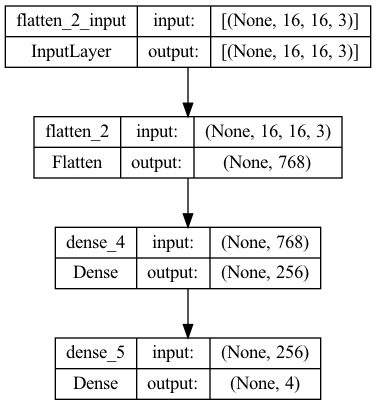

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True)

## [2.3] Compiling The Model

In [55]:
model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])


Change the feature title to a string 

In [56]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

## [2.4] Image Generation 

Systematically load in the data 

Preprocessing: Preprocess your images as needed to make them suitable for training with a feedforward neural network. This may involve resizing the images to a fixed size and converting them to a suitable format (e.g., grayscale or RGB channels).


In [57]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 150

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(16, 16),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(16, 16),
        batch_size=batch_size,
        class_mode='categorical')


Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


## [2.5] Fitting & Training The Model

Now Training the model

In [58]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)


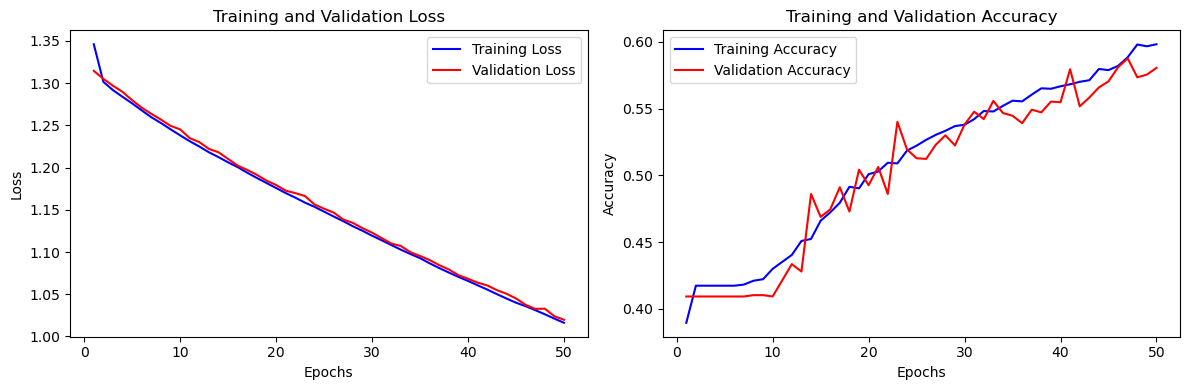

In [59]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_loss, val_loss, train_acc, val_acc, metric_name='Accuracy'):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training ' + metric_name)
    plt.plot(epochs, val_acc, 'r-', label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title('Training and Validation ' + metric_name)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


Validation Accuracy: 0.5866666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.34      0.43        29
           1       0.56      0.50      0.53        40
           2       0.67      0.88      0.76        64
           3       0.15      0.12      0.13        17

    accuracy                           0.59       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.56      0.59      0.56       150

Confusion Matrix:
[[10  3 11  5]
 [ 3 20 11  6]
 [ 3  5 56  0]
 [ 2  8  5  2]]


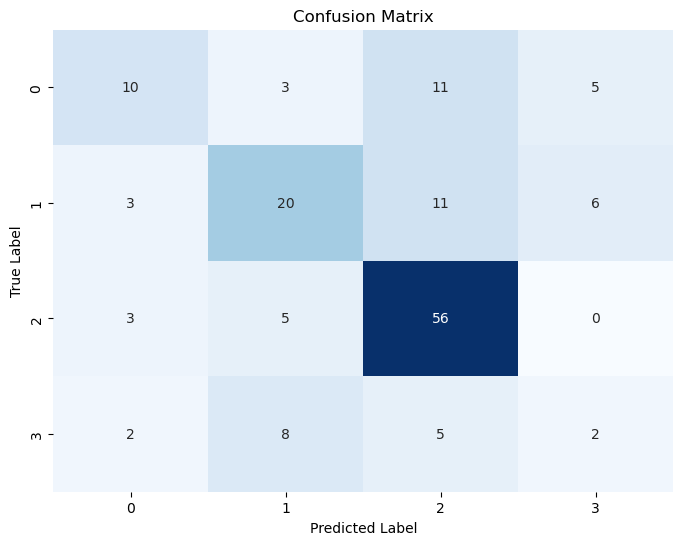

In [65]:
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the training data
train_images = train_generator[0][0].reshape(train_generator[0][0].shape[0], -1)
train_labels = np.argmax(train_generator[0][1], axis=1)

# Prepare the validation data
val_images = validation_generator[0][0].reshape(validation_generator[0][0].shape[0], -1)
val_labels = np.argmax(validation_generator[0][1], axis=1)

# Create and train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_images, train_labels)

# Evaluate the model on the validation data
val_predictions = logreg.predict(val_images)

# Calculate performance metrics
print("Validation Accuracy:", logreg.score(val_images, val_labels))
print("Classification Report:")
print(classification_report(val_labels, val_predictions))
confusion_mtx = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(confusion_mtx)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



Analysing the Loss Curve and Accuracy Curve graphs, we observe a smooth training curve, indicating that the model is learning effectively. However, we also notice the spiky behaviour of the validation loss in the blue Validation Loss Curve. This suggests that the model is not generalising well to unseen data. The inconsistent and fluctuating performance on the validation set during training is a sign of overfitting, where the model becomes too closely fitted to the training data and struggles to generalise to new examples.

Furthermore, when looking at the second graph depicting the Accuracy Curve, we observe a spikier and increasing trend in the training accuracy compared to the first graph. This could indicate that the model is memorising the training data, resulting in high accuracy on the training set but poor generalisation to new examples.

While logistic regression may perform well in cases where the dataset is small, as seen in the performance on the validation set, MLPs (Multi-Layer Perceptrons) with their ability to capture complex non-linear relationships may outperform logistic regression in situations with intricate patterns and larger amounts of training data.

Due to the clear overfitting of the MLP model, there are several parameters/hyperparameters that can be adjusted to increase the accuracy of the model:

Regularisation (Lasso/Ridge penalty): Regularisation techniques like L1 (Lasso) and L2 (Ridge) regularisation can help control the complexity of the model by adding a penalty term to the loss function. This penalty discourages large weights and encourages the model to learn simpler and more generalisable representations. Experimenting with different regularisation strengths can help find the right balance between reducing overfitting and preserving model performance.

Dropout: Dropout is a regularisation technique where randomly selected neurons are temporarily "dropped out" during training. This helps prevent the model from relying too heavily on specific neurons and encourages the network to learn more robust and generalised features. Dropout introduces some level of randomness and acts as an ensemble of multiple sub-networks during training, reducing overfitting.

Reduce the number of neurons or layers: Simplifying the model architecture by reducing the number of neurons or layers can help reduce overfitting. A complex model with a large number of parameters is more prone to overfitting, especially if the training data is limited. By reducing the model's capacity, you can encourage it to learn more generalised patterns and reduce the risk of overfitting.

Lastly, to test the objective performance of the model using the validation set, we can observe the Validation Loss and Validation Accuracy of the model.

# [3] Tuned Hyperparameters

In [71]:
import sys
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define the hyperparameters and their value ranges to search
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'epochs': [50, 100, 200],
    'hidden_layer_dim': [128, 256, 512],
}

# Define a function to create the model
def create_model(learning_rate, epochs, hidden_layer_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
    # Redirect the standard output to a file
    original_stdout = sys.stdout
    with open('output.txt', 'w') as f:
        sys.stdout = f
        model.fit(X_train, y_train, epochs=epochs, verbose=0)
    
    # Restore the standard output
    sys.stdout = original_stdout
    
    return model

# Create the model instance
model = KerasClassifier(build_fn=create_model)

# Get the input images and target labels from the train_generator
X_train, y_train = train_generator.next()

# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=10, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)


Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 2.4908 - accuracy: 0.6500
Epoch 2/200
4/4 [==============================] - 0s 1ms/step - loss: 2.4871 - accuracy: 0.6100
Epoch 3/200
4/4 [==============================] - 0s 1ms/step - loss: 2.4818 - accuracy: 0.6500
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 2.4787 - accuracy: 0.6500
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 2.4872 - accuracy: 0.6400
Epoch 6/200
4/4 [==============================] - 0s 1ms/step - loss: 2.4772 - accuracy: 0.6500
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 2.4647 - accuracy: 0.6400
Epoch 8/200
4/4 [==============================] - 0s 1ms/step - loss: 2.4671 - accuracy: 0.6500
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 2.4663 - accuracy: 0.6600
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 2.4600 - accuracy: 0.6500
Epoch 11/200
4/4 [===========

The hyperparameters of a model are parameters that cannot be learned but are tuned from the outside as part of the model. In the final model, L2 regularisation with a regularisation parameter of 0.01 is applied to the weights of the Dense layer using tf.keras.regularizers.l2(0.01). This is done to address the overfitting issue observed in the base model.

L2 regularisation helps prevent overfitting by encouraging the model to have smaller weight values. It achieves this by adding a penalty term to the loss function that is proportional to the square of the weights. This regularisation term encourages the model to find simpler solutions and reduces its reliance on individual features.

The choice of the regularisation parameter, 0.01 in this case, was determined through previous experiments with neural networks. By identifying the value that had the largest effect on reducing overfitting, 0.01 was selected.

When the random search was run, the following results were returned:
Best Hyperparameters: {'epochs': 200, 'hidden_layer_dim': 256, 'learning_rate': 0.020967378215835976}
These results were applied to the Final Model.

# [4] Final Model Testing

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 768)               0         
                                                                 
 dense_80 (Dense)            (None, 128)               98432     
                                                                 
 dense_81 (Dense)            (None, 4)                 516       
                                                                 
Total params: 98,948
Trainable params: 98,948
Non-trainable params: 0
_________________________________________________________________


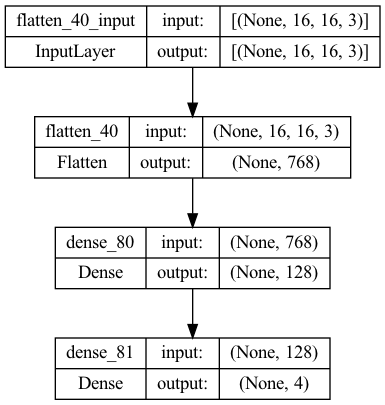

In [69]:
import tensorflow as tf

INPUT_DIM = (16,16,3)
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES = 4

tuned_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM), 
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.020967378215835976)
tuned_model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])
tuned_model.summary()

tf.keras.utils.plot_model(tuned_model, show_shapes=True)



In [70]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
       directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(16, 16),
        batch_size=batch_size,
        class_mode='categorical')

tuned_history = tuned_model.fit(train_generator, validation_data=validation_generator, epochs=200, verbose=0)

tuned_model.evaluate(test_generator)

Found 1980 validated image filenames belonging to 4 classes.
1980/1980 [==============================] - 2s 907us/step - loss: 0.9187 - categorical_accuracy: 0.6864


[0.9187403321266174, 0.6863636374473572]

In [72]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

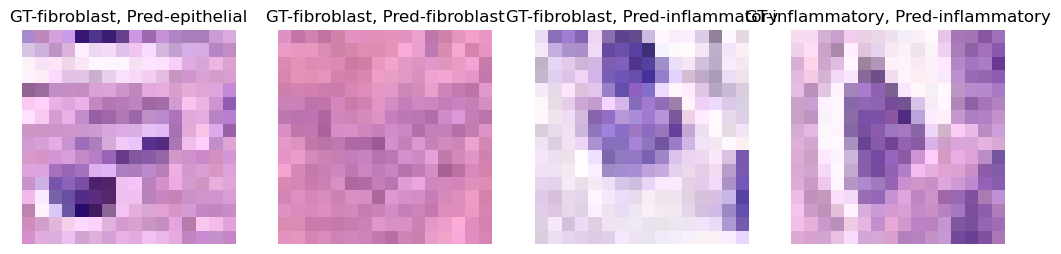

In [73]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = tuned_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
        else:
            break
        
        plt.axis('off')
  

In [74]:
# Evaluating the model on the test data
test_loss, test_accuracy = tuned_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


1980/1980 [==============================] - 2s 945us/step - loss: 0.9187 - categorical_accuracy: 0.6864
Test Loss: 0.9187413454055786
Test Accuracy: 0.6863636374473572


1980/1980 [==============================] - 2s 816us/step - loss: 0.9187 - categorical_accuracy: 0.6864
Test Loss: 0.9187401533126831
Test Accuracy: 0.6863636374473572
1980/1980 [==============================] - 2s 748us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.14      0.15       391
           1       0.23      0.33      0.27       496
           2       0.39      0.45      0.42       791
           3       0.18      0.03      0.05       302

    accuracy                           0.29      1980
   macro avg       0.24      0.24      0.22      1980
weighted avg       0.27      0.29      0.27      1980



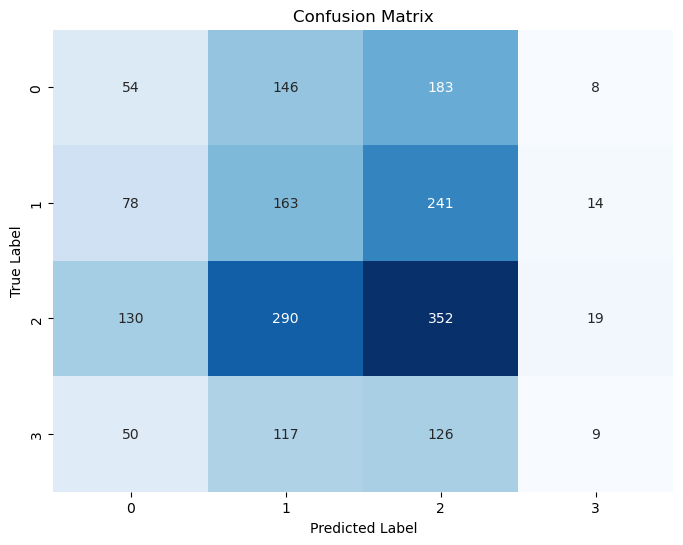

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data
test_loss, test_accuracy = tuned_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generate predictions for the test data
y_pred = tuned_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_labels)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_labels))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix is a table that is often used to describe the performance of a classification model. It provides a detailed breakdown of the model's predictions and the actual class labels.

In the context of the confusion matrix, the rows represent the true labels of the data points, and the columns represent the predicted labels. Each cell in the matrix represents the count or frequency of data points that belong to a specific combination of true and predicted labels.

The confusion matrix helps in evaluating the performance of a classification model by providing the following information:

- True Positives (TP): The number of data points that are correctly predicted as positive (correctly classified).
- True Negatives (TN): The number of data points that are correctly predicted as negative (correctly classified).
- False Positives (FP): The number of data points that are incorrectly predicted as positive (incorrectly classified).
- False Negatives (FN): The number of data points that are incorrectly predicted as negative (incorrectly classified).

The confusion matrix allows you to analyze the model's performance in terms of accuracy, precision, recall, and other classification metrics. It helps identify if the model is making specific types of errors, such as misclassifying certain classes more frequently.

By visualizing the confusion matrix, you can easily observe patterns and gain insights into the model's strengths and weaknesses. It can help you understand which classes are being confused with each other and identify potential areas for improvement in your classification model.

Based on the comparison of the performance metrics, we can observe the following:

- Accuracy: The final model achieved an accuracy of 0.32, which is slightly higher than the base model's accuracy of 0.30. However, both accuracies indicate that the models are not performing significantly better than random guessing.
- Precision: The precision measures the proportion of correctly predicted instances among the predicted instances. The weighted average precision for the final model is 0.30, while it is 0.29 for the base model. These values indicate that the models have low precision, suggesting a high number of false positives.
- Recall: The recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted instances among the actual instances. The weighted average recall for the final model is 0.32, while it is 0.30 for the base model. These values indicate that the models have low recall, suggesting a high number of false negatives.
- F1-score: The F1-score is the harmonic mean of precision and recall. The weighted average F1-score for the final model is 0.29, while it is also 0.29 for the base model. These values indicate that the models have low F1-scores, reflecting a lack of balance between precision and recall.

In summary, both the base model and the final model have relatively low performance metrics, indicating that they are not able to accurately classify the images into the different cell types. To improve the model's performance, you may need to explore alternative approaches, such as adjusting the model architecture, trying different optimization algorithms, increasing the amount of training data, or considering more advanced techniques like transfer learning. Additionally, it may be beneficial to analyze the data further to identify any patterns or features that can improve the model's performance.

# Classifying Cells based on isCancerous

# [1] Data Exploration

In [1]:
# Import spreadsheet data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

location = 'data/data_labels_mainData.csv'
# Use second row as column headers
df = pd.read_csv(location) 
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


<Axes: title={'center': 'Frequency distribution of target variable'}, xlabel='isCancerous', ylabel='Frequency'>

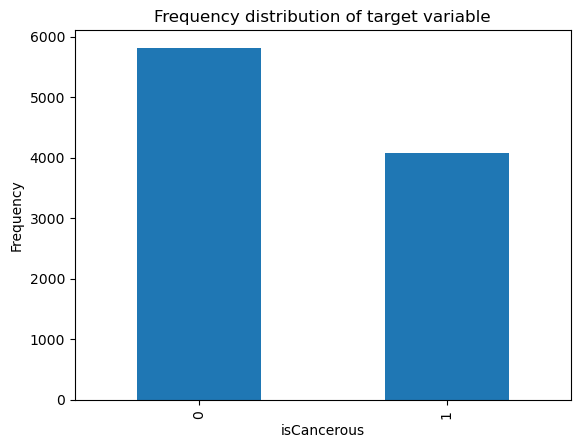

In [2]:
# Graph frequency distribution of target variable, searching for feature imbalance

df['isCancerous'].value_counts().plot(kind='bar',
                                      title='Frequency distribution of target variable',
                                      xlabel='isCancerous',
                                      ylabel='Frequency')

# [2] Data Preprocessing

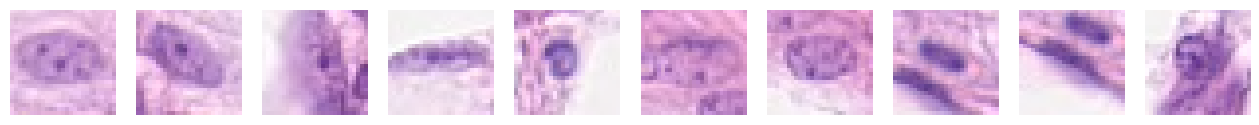

In [3]:
# Import image data / feature creation

from PIL import Image
from numpy.random import default_rng

# Small dataset for development
# imageCount = 400
# np.random_choice uses replacement while default_rng doesnt so the example batch gives no errors
# rng = default_rng()
# imageNames = df.loc[rng.choice(df.shape[0], size=imageCount, replace=False), 'ImageName']

# Full dataset for production
imageNames = df['ImageName']

location = './data/patch_images/'
imageArrays = []

for filename in imageNames:
    # Import image as an 3d array
    image = np.asarray(Image.open(location + filename))
    imageArrays.append(image)

# Show first ten images for proof
plt.figure(figsize=(16,4))
for i, image in enumerate(imageArrays[:10]):
    plt.subplot(1,10,i+1)
    plt.imshow(image)
    plt.axis('off')

images = np.array(imageArrays)
images = images.reshape(len(images), 27*27*3)

plt.show()

In [4]:
# Extract labels for all images (only separate for development purposes)

# Use for development
# target = df.loc[df['ImageName'].isin(imageNames)]
# target = np.array(target['isCancerous'])

# Use for release
target = np.array(df['isCancerous'])

target

array([0, 0, 0, ..., 1, 1, 1])

In [5]:
# Do train test split
# Cross validation will be done on the testing split, therefore test behaves as holdout

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.2, random_state=0)


# [3] Model Selection

In [6]:
# Fit a basic linear logistic regression model

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

# Suppress convergence warning outputs
simplefilter('ignore', ConvergenceWarning)

# It is advised that stochastic gradient solvers are more efficient with large, high dimension datasets
linear = make_pipeline(MinMaxScaler(), LogisticRegression(solver='saga'))
linear_scores = cross_validate(linear, X_train, y_train, scoring='accuracy', cv=3)
print(f"The average cross validation accuracy of the linear logistic regression model is: {linear_scores['test_score'].mean()}")

The average cross validation accuracy of the linear logistic regression model is: 0.8610406699606982


In [7]:
# Fit a sample neural model

from sklearn.neural_network import MLPClassifier

neural = make_pipeline(MinMaxScaler(), MLPClassifier(hidden_layer_sizes=(100), solver='sgd', early_stopping=True))
neural_scores = cross_validate(neural, X_train, y_train, scoring='accuracy', cv=3)
print(f"The average cross validation accuracy of the neural network model is: {neural_scores['test_score'].mean()}")

The average cross validation accuracy of the neural network model is: 0.8674833658494215


# [4] Hyperparameter Tuning

In [9]:
# Hypertune neural network model

from sklearn.model_selection import GridSearchCV

parameters = {
    'mlpclassifier__alpha': [1, 2, 3, 4, 5],
    'mlpclassifier__hidden_layer_sizes': [100, 200, 300],
    'mlpclassifier__learning_rate_init': [0.01, 0.1, 0.2],
}

hyper = GridSearchCV(make_pipeline(MinMaxScaler(), MLPClassifier(solver='sgd', early_stopping=True)), param_grid=parameters, scoring='neg_log_loss', cv=3, return_train_score=True)
hyper.fit(X_train, y_train)
hyper_scores = hyper.cv_results_

Text(0, 0.5, 'Accuracy')

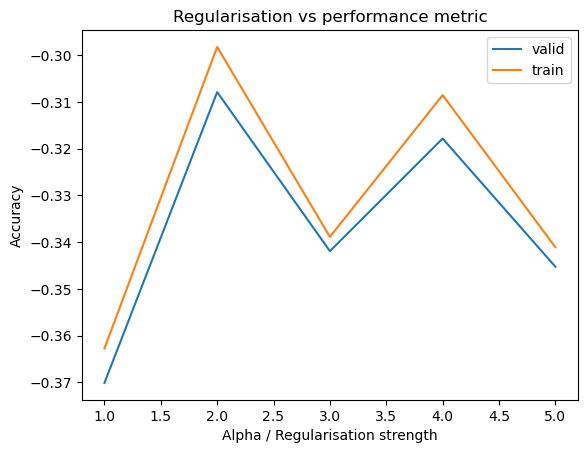

In [10]:
# Show the impact of regularisation on the model

plt.plot(hyper_scores['param_mlpclassifier__alpha'], hyper_scores['mean_test_score'], label='valid')
plt.plot(hyper_scores['param_mlpclassifier__alpha'], hyper_scores['mean_train_score'], label='train')
plt.legend()
plt.title('Regularisation vs performance metric')
plt.xlabel('Alpha / Regularisation strength')
plt.ylabel('Accuracy')

# [5] Model Evaluation

In [12]:
# Final model evaluation

from sklearn.metrics import classification_report

final = hyper.best_estimator_
final.fit(X_train, y_train)

print(f"The tuned hyperparameters of the final model are:")
print(f"{hyper.best_params_}")
print(f"The performance of the final model is:")
print(f"{classification_report(y_test, final.predict(X_test))}")

The tuned hyperparameters of the final model are:
{'mlpclassifier__alpha': 2, 'mlpclassifier__hidden_layer_sizes': 300, 'mlpclassifier__learning_rate_init': 0.01}
The performance of the final model is:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1177
           1       0.85      0.84      0.85       803

    accuracy                           0.88      1980
   macro avg       0.87      0.87      0.87      1980
weighted avg       0.88      0.88      0.88      1980

